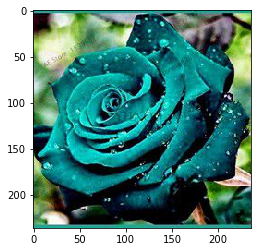

(236, 236, 3)


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import PIL
from PIL import Image

im=Image.open('rose.jpg')
plt.imshow(im)
plt.show()
print(np.shape(im))

def ReLU(x):
    x[x<0]=0
    return x;

def Sig(x):
    return 1/(1+np.exp(-x))

def SoftMax(x):
    z=np.exp(x)
    return z/np.sum(z)

def dot(x,alpham,alpham0):
    return (np.matmul(alpham.T,x)+alpham0)


## Convolution function:-

In [3]:
def convolution(img,L,s,padding,func):
    l=int(L/2) # half of L
    X=np.asarray(img)
    if padding==1:
        X=np.pad(X,[(l,),(l,),(0,)],mode='constant')
        
    m,n,d=np.shape(X)

    filt=np.random.normal(0.1,0.2,(L,L,3)) 

    O=np.zeros((int((m-2*l)/s),int((n-2*l)/s)))
    
    # for each i,j consider the square of elements L*L around it, multiply pointwise wth the filter and add up.
    for i in range(l,m-l,s):
        for j in range(l,n-l,s):              
            for k in range(i-l,i+l+1):
                for p in range(j-l,j+l+1):
                    for q in range(d):
                        O[int((i-l+1)/s)-1][int((j-l+1)/s)-1]+=X[k][p][q]*filt[k-i+l][p-j+l][q]
                        
    if func=='ReLU':
        O=ReLU(O)
    elif func=='Sig':
        O=Sig(O)

    return O

Testing of Convolution function:-

(118, 118)


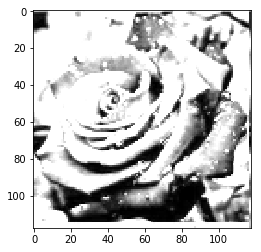

In [4]:
conv_out=convolution(im,L=3,s=2,padding=1,func='ReLU')
#print(conv_out)
conv_out_im=Image.fromarray(conv_out)

plt.imshow(conv_out_im)
print(np.shape(conv_out_im))
plt.show()


## Pooling function:-

In [5]:
def pooling(conv_act_map_out,L,s,padding,pool):
    l=int(L/2) # half of the dimension of the pooling filter
    X=conv_act_map_out
    if padding==1:
        X=np.pad(X,[(l,),(l,)],mode='constant')
        
    m,n=np.shape(X)

    O=np.zeros((int((m-2*l)/s),int((n-2*l)/s)))
    
    max_val=0
    
    for i in range(l,m-l,s):
        for j in range(l,n-l,s):
            for k in range(i-l,i+l+1):
                for p in range(j-l,j+l+1):
                    if pool=='Max':
                        if max_val<X[k][p]:
                             O[int((i-l+1)/s)-1][int((j-l+1)/s)-1]=X[k][p]
                    elif pool=='Avg':
                         O[int((i-l+1)/s)-1][int((j-l+1)/s)-1]+=X[k][p]/float(L*L)
                        
    return O
                        
                        
    

Testing of pooling function:-

(38, 38)


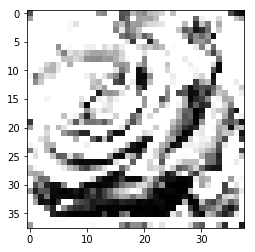

In [6]:
pool_out=pooling(conv_out,L=5,s=3,padding=0,pool='Max')
#print(pool_out)

pool_out_im=Image.fromarray(pool_out)
plt.imshow(pool_out_im)
print(np.shape(pool_out_im))
plt.show()


## Convolution layer function:-

In [7]:
def conv_layer(img,L,s,padding,func,no_of_filters):
    out=[]
    for i in range(no_of_filters):
        out.append(convolution(img,L,s,padding,func))
    return out

Testing Convolution layer function:-

(3, 118, 118) 
depth*width*height
In the function, we are appending the transformation for each image of the volume, so we get depth axes first


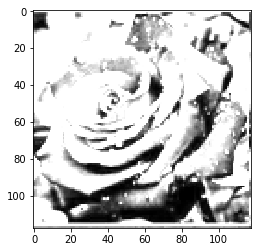

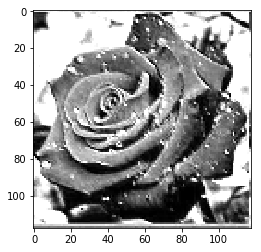

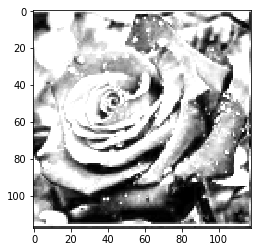

In [8]:
filter_count=3
conv_layer_out=conv_layer(im,L=3,s=2,padding=1,func='ReLU',no_of_filters=filter_count)
conv_layer_out=np.array(conv_layer_out)
print(np.shape(conv_layer_out),'\ndepth*width*height')
print('In the function, we are appending the transformation for each image of the volume, so we get depth axes first')

for i in range(filter_count):
    conv_layer_out_im=Image.fromarray(conv_layer_out[i])
    plt.imshow(conv_layer_out_im)
    plt.show()

## Pooling volume function:-

In [9]:
def pool_layer(act_map_volume,L,s,padding,pool):
    out=[]
    for i in range(len(act_map_volume)):
        out.append(pooling(act_map_volume[i,:,:],L,s,padding,pool))
    return out


Testing pooling volume function:-

(3, 59, 59)


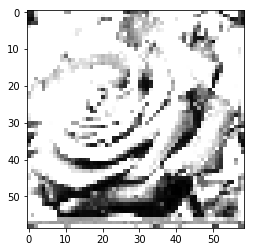

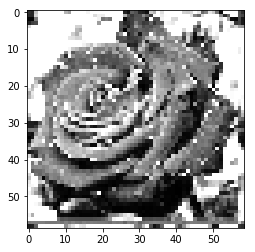

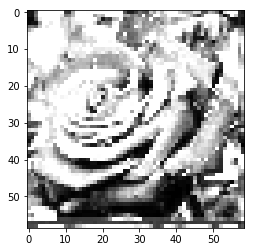

In [10]:
pool_layer_out=pool_layer(conv_layer_out,L=3,s=2,padding=1,pool='Max')
pool_layer_out=np.array(pool_layer_out)
print(np.shape(pool_layer_out))

for i in range(len(pool_layer_out)):
    pool_layer_out_im=Image.fromarray(pool_layer_out[i])
    plt.imshow(pool_layer_out_im)
    plt.show()

## Composition of layers:-

In [11]:
def composition_of_layers(im,order_of_layers,filter_size_order,stride_order,pad_order,pool_type_order,filters_per_layer,act_order):
    X=np.asarray(im)
    k=0
    j=0
    for i in range(len(order_of_layers)):
        if order_of_layers[i]=='conv':
            if k!=0:
                X=np.swapaxes(X,0,2)
            imageX=Image.fromarray(X,'RGB')
            X=conv_layer(imageX,L=filter_size_order[i],s=stride_order[i],padding=pad_order[i],func=act_order[k],no_of_filters=filters_per_layer[k])
            k+=1
            X=np.array(X)
            print('After',i+1,'th Convolution:\n',np.shape(X))
            for i in range(len(X)):
                out_im=Image.fromarray(X[i])
                plt.imshow(out_im)
                plt.show()
            print('\n\n')
        elif order_of_layers[i]=='pool':
            X=pool_layer(X,L=filter_size_order[i],s=stride_order[i],padding=pad_order[i],pool=pool_type_order[j])
            j+=1
            X=np.array(X)
            print('After',i+1,'th Pooling:\n',np.shape(X))
            for i in range(len(X)):
                out_im=Image.fromarray(X[i])
                plt.imshow(out_im)
                plt.show()
            print('\n\n')
            
    return X

## Unravelling function:-

In [15]:
def unravelling(comp_layer_out,out_dim):
    X=comp_layer_out.flatten()
    s=np.shape(X)
    s=[s[0],out_dim]
    r=np.random.normal(0,0.01,s)
    out=np.dot(X,r)
    return out

## MLP function:-

In [16]:
def MLP(x,n,M_array,out_dim,activn):
    L=len(x)
    for i in range(n):
        M=M_array[i]
        alpham=np.random.normal(0,0.01,(L,M))
        alpham0=np.random.normal(0,0.01,M)
        x=dot(x,alpham,alpham0)
        
        if activn[i]=='ReLU':
            x=ReLU(x)
        elif activn[i]=='Sig':
            x=Sig(x)
        #print('\n',x,'\n')
        L=M
    y=x
    M=out_dim
    alpham=np.random.normal(0,0.01,(L,M))
    alpham0=np.random.normal(0,0.01,M)
    x=dot(x,alpham,alpham0)
    y=SoftMax(x)
    
    return x,y


## Connecting the composition of convolution layer functions to the MLP function via the unraveling function:-

After 1 th Convolution:
 (3, 118, 118)


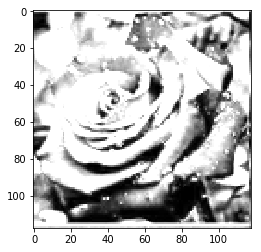

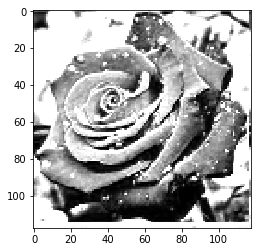

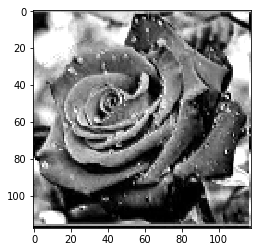




After 2 th Pooling:
 (3, 59, 59)


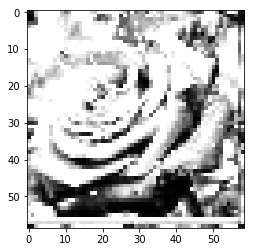

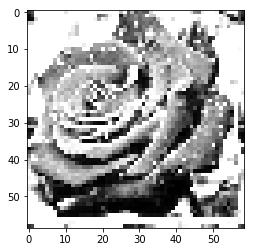

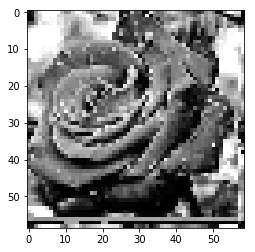




After 3 th Convolution:
 (2, 29, 29)


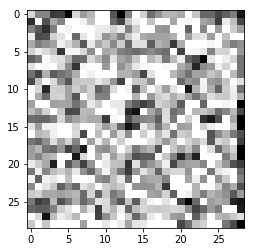

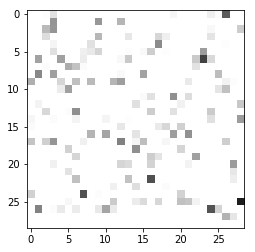




After 4 th Pooling:
 (2, 14, 14)


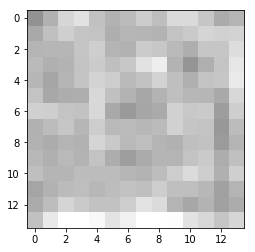

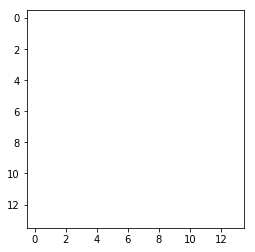




Output after Unravelling:-
 [ 4.82228726e+01  5.76653551e+01  2.92657035e+01 -1.23600897e+01
 -4.93773248e+00 -1.03639340e+02 -3.36192073e+01 -4.91957489e+01
  3.00813480e+01 -5.71131028e+01  1.57127236e+01  5.88429753e+01
 -5.71207634e+01 -3.29498545e+01 -4.97236078e+01 -6.92483555e+01
  9.52856658e+00 -7.21235003e+01 -6.35477244e+01 -4.03237497e+01
 -1.25315160e+01  8.47732178e+01  1.50337053e+01 -2.42735483e+01
  7.31484037e+00  2.86707621e+00  7.44430792e+01 -4.30827858e+01
  1.41340961e+02  4.33472040e+01 -1.32855407e+00  7.18407529e+00
  5.42677482e+01 -1.02935515e+02 -2.32316689e+01 -5.33843293e+00
 -3.98008066e+01  3.97387629e+01 -4.83974496e+01  1.85817581e+00
 -7.69047186e+01  4.85753482e+01  1.90702891e-02  1.54432726e-01
 -9.30400515e+01 -6.76862551e+01  5.71428153e+01  2.82361308e+01
  8.48299480e+00  1.00654892e+02 -4.86364127e+01 -1.54754087e+01
  2.70103625e+01  3.00031227e+01 -9.42676380e+01  3.14931685e+01
 -2.04596159e+00 -8.82269684e+01 -4.22575040e+01 -3.0120634

In [17]:
layer_order=['conv','pool','conv','pool']
filter_sizes=[3,5,3,5]
strides=[2,2,2,2]
padings=[1,1,1,1]
poolings=['Max','Avg'] # for corresponding pooling layers in order
filter_dimn_per_layer=[3,2] # for corresponding conv layers  in order
activns=['ReLU','ReLU']  # for corresponding conv layers  in order

# passing through composite layer
comp_layer_out=composition_of_layers(im,layer_order,filter_sizes,strides,padings,poolings,filter_dimn_per_layer,activns)


# unravelling
mlp_inp=unravelling(comp_layer_out,64)
print('Output after Unravelling:-\n',mlp_inp,'\nLength of the vector:',len(mlp_inp))

# passing through MLP layer
without_softmax,with_softmax=MLP(mlp_inp,3,[32,16,8],4,['Sig','Sig','ReLU'])
print('\nOutput without softmax function:-\n',without_softmax,'\nOutput with softmax function:-\n',with_softmax)